# Assignment 1.1  
Develop your own CNN-based Image Classification model using the CIFAR-10 dataset. Visualize the class-wise sample distribution in the dataset using Histogram and Pie Chart. Using validation set, tune the hyperparameters such as number of convolution layers, number of filters, filter size, batch size, epochs, learning rate, optimizers: ADAM or RMSprop or SGD. Save the best model and report its performance on test set in terms of accuracy, precision, recall, weighted F1 score and macro F1 score. Visualize the epoch vs training accuracy and epoch vs validation accuracy

In [1]:
# ================================
# CIFAR-10 Classification with AlexNet - PyTorch
# Ready for Google Colab
# ================================
!pip install torch torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


In [2]:
# --------------------------------
# 2. Load and Transform CIFAR-10
# --------------------------------
# AlexNet expects 224x224 input images (originally for ImageNet)
transform = transforms.Compose([
    transforms.Resize(224), # resize CIFAR-10 (32x32) to 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split into train/validation
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_set, [train_size, val_size])

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

classes = train_set.classes


/var/folders/ym/zhxg1h7j6bbfrngysk1xkxf00000gn/T/ipykernel_1256/2766265359.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=train_labels, palette="Set2")


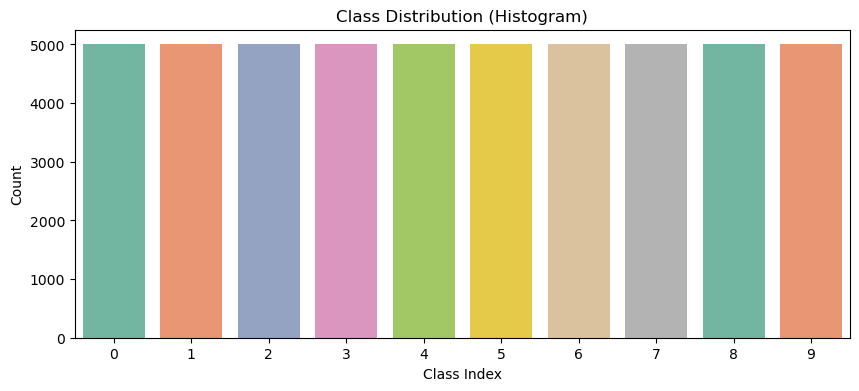

In [3]:
# --------------------------------
# 3. Visualize Class Distribution
# --------------------------------
train_labels = [train_set[i][1] for i in range(len(train_set))]

plt.figure(figsize=(10,4))
sns.countplot(x=train_labels, palette="Set2")
plt.title("Class Distribution (Histogram)")
plt.xlabel("Class Index")
plt.ylabel("Count")
plt.show()


In [4]:
# --------------------------------
# 4. AlexNet Model Definition
# --------------------------------
import torchvision.models as models

def get_alexnet_model(num_classes=10):
    model = models.alexnet(pretrained=False) # pretrained=True if you want ImageNet weights
    model.classifier[6] = nn.Linear(4096, num_classes) # adjust final layer for CIFAR-10
    return model.to(device)


In [5]:
# --------------------------------
# 5. Training Function
# --------------------------------
def train_model(optimizer_type="adam", num_epochs=10): # fewer epochs for AlexNet (heavier model)
    model = get_alexnet_model(num_classes=10)
    criterion = nn.CrossEntropyLoss()

    if optimizer_type.lower() == "adam":
        optimizer = optim.Adam(model.parameters(), lr=0.0001) # lower LR for AlexNet
    elif optimizer_type.lower() == "rmsprop":
        optimizer = optim.RMSprop(model.parameters(), lr=0.0001)
    else:
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    train_acc_history, val_acc_history = [], []

    for epoch in range(num_epochs):
        model.train()
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_accuracy = 100 * correct / total

        # Validation accuracy
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_accuracy = 100 * val_correct / val_total

        train_acc_history.append(train_accuracy)
        val_acc_history.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Acc: {train_accuracy:.2f}%, Val Acc: {val_accuracy:.2f}%")

    return model, train_acc_history, val_acc_history


In [6]:

# First, define the device for Mac with Apple Silicon
import torch
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# --------------------------------
# 6. Train with Adam, RMSprop, SGD
# --------------------------------
model_adam, train_acc_adam, val_acc_adam = train_model(optimizer_type="adam", num_epochs=20)
model_rms, train_acc_rms, val_acc_rms = train_model(optimizer_type="rmsprop", num_epochs=20)
model_sgd, train_acc_sgd, val_acc_sgd = train_model(optimizer_type="sgd", num_epochs=20)


/opt/anaconda3/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/20], Train Acc: 40.99%, Val Acc: 54.35%
Epoch [2/20], Train Acc: 58.69%, Val Acc: 63.59%
Epoch [3/20], Train Acc: 67.45%, Val Acc: 70.88%
Epoch [4/20], Train Acc: 73.33%, Val Acc: 73.55%
Epoch [5/20], Train Acc: 77.71%, Val Acc: 75.75%
Epoch [6/20], Train Acc: 80.87%, Val Acc: 77.64%
Epoch [7/20], Train Acc: 83.13%, Val Acc: 78.96%
Epoch [8/20], Train Acc: 85.94%, Val Acc: 80.29%
Epoch [9/20], Train Acc: 88.06%, Val Acc: 80.30%
Epoch [10/20], Train Acc: 90.11%, Val Acc: 82.08%
Epoch [11/20], Train Acc: 91.69%, Val Acc: 81.86%
Epoch [12/20], Train Acc: 93.09%, Val Acc: 80.07%
Epoch [13/20], Train Acc: 93.92%, Val Acc: 82.49%
Epoch [14/20], Train Acc: 94.80%, Val Acc: 82.17%
Epoch [15/20], Train Acc: 95.75%, Val Acc: 81.94%
Epoch [16/20], Train Acc: 96.00%, Val Acc: 82.15%
Epoch [17/20], Train Acc: 96.44%, Val Acc: 81.83%
Epoch [18/20], Train Acc: 96.78%, Val Acc: 82.55%
Epoch [19/20], Train Acc: 97.13%, Val Acc: 81.22%
Epoch [20/20], Train Acc: 97.07%, Val Acc: 82.52%
Epoch [1/

In [7]:
# --------------------------------
# 7. Evaluate on Test Set
# --------------------------------
def evaluate_model(model):
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    weighted_f1= f1_score(all_labels, all_preds, average='weighted')
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    print("\nTest Set Evaluation:")
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1 Score (weighted): {weighted_f1:.4f}")
    print(f"F1 Score (macro): {macro_f1:.4f}")
    print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=classes))

# Evaluate all 3 optimizers
evaluate_model(model_adam)
evaluate_model(model_rms)
evaluate_model(model_sgd)



Test Set Evaluation:
Accuracy: 82.74%
Precision (weighted): 0.8292
Recall (weighted): 0.8274
F1 Score (weighted): 0.8274
F1 Score (macro): 0.8274

Classification Report:
               precision    recall  f1-score   support

    airplane       0.81      0.88      0.84      1000
  automobile       0.91      0.91      0.91      1000
        bird       0.78      0.72      0.75      1000
         cat       0.66      0.69      0.68      1000
        deer       0.87      0.76      0.81      1000
         dog       0.75      0.78      0.76      1000
        frog       0.89      0.87      0.88      1000
       horse       0.88      0.86      0.87      1000
        ship       0.91      0.89      0.90      1000
       truck       0.83      0.92      0.87      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000


Test Set Evaluation:
Accuracy: 80.34%
Precision (weighted): 0.8142
R

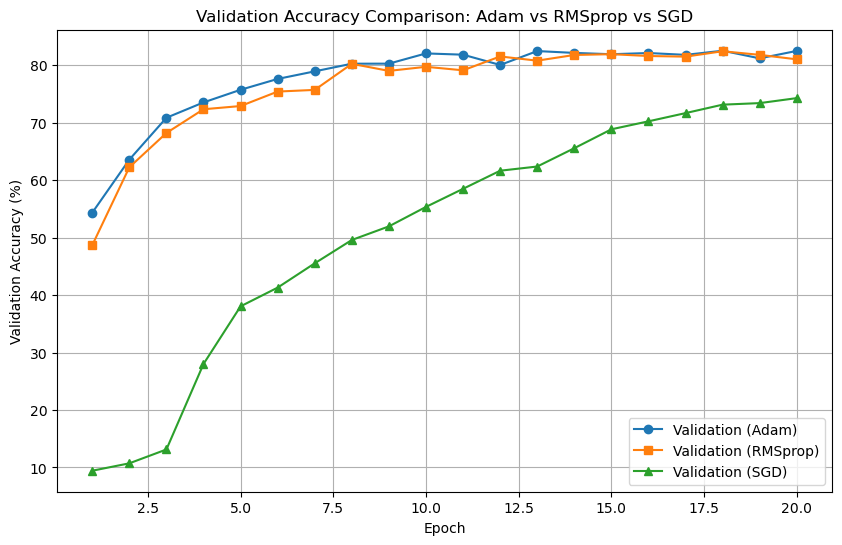

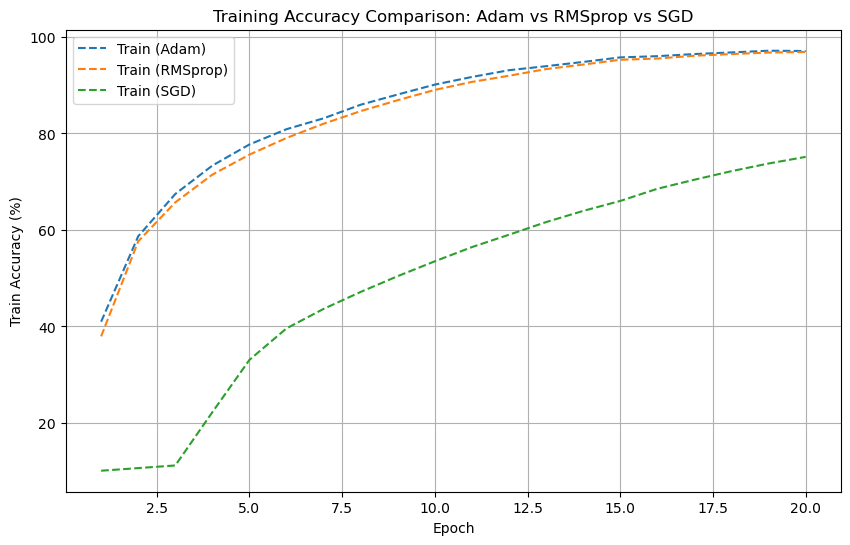

In [8]:
# --------------------------------
# 8. Plot Training vs Validation Accuracy Comparison
# --------------------------------
plt.figure(figsize=(10,6))
plt.plot(range(1, len(val_acc_adam)+1), val_acc_adam, label="Validation (Adam)", marker="o")
plt.plot(range(1, len(val_acc_rms)+1), val_acc_rms, label="Validation (RMSprop)", marker="s")
plt.plot(range(1, len(val_acc_sgd)+1), val_acc_sgd, label="Validation (SGD)", marker="^")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy Comparison: Adam vs RMSprop vs SGD")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_acc_adam)+1), train_acc_adam, label="Train (Adam)", linestyle="--")
plt.plot(range(1, len(train_acc_rms)+1), train_acc_rms, label="Train (RMSprop)", linestyle="--")
plt.plot(range(1, len(train_acc_sgd)+1), train_acc_sgd, label="Train (SGD)", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Train Accuracy (%)")
plt.title("Training Accuracy Comparison: Adam vs RMSprop vs SGD")
plt.legend()
plt.grid(True)
plt.show()